# Module 2, Section 2: Eval-Driven Development

The benefit of building out a dataset and eval metrics upfront is that we have a quantitative signal that we can use to understand how changes to our app impact downstream peformance. Without this, we're just flying blind!


<div align="center">
    <img src="../../images/eval_process.png">
</div>

### Systematically Improving Our Application

Our baseline evaluation revealed weaknesses in the current database sub-agent:

**The Problem:**
- ❌ **Excessive tool calls**: Sequential chains of `get_customer_orders` → multiple `get_order_status` → multiple `get_order_item_price` calls, etc.
- ❌ **Missing capabilities**: Can't aggregate (SUM, COUNT, AVG), filter (WHERE), or JOIN across tables - so relies on in memory math
- ❌ **Limited flexibility**: Rigid tools can't adapt to complex or novel queries

**Possible Solution:**
Build a flexible SQL agent that generates custom queries at runtime to answer any database question efficiently.

Let's use our evaluation setup to drive a targeted improvement!

## 1. Setup

We'll build a SQL agent that can generate custom queries to answer complex database questions.

<div align="center">
    <img src="../../images/db_agent_improvement.png">
</div>

In [1]:
from dotenv import load_dotenv
from tools.database import get_database

load_dotenv()

# Get database connection (lazy loaded)
db = get_database()

# Extract schema once - we'll inject this into the agent's system prompt
table_info = db.get_table_info()

## 2. Build SQL Agent

Create a tool that executes SQL queries and an agent that can generate those queries on-demand using `create_agent()` abstraction.


In [2]:
from langchain.tools import tool


@tool
def execute_sql(query: str) -> str:
    """Execute a SELECT query against the TechHub database.

    Safety: Only SELECT queries allowed - no INSERT/UPDATE/DELETE/etc.
    """
    # Safety check: Only allow SELECT queries
    if not query.strip().upper().startswith("SELECT"):
        return "Error: Only SELECT queries are allowed."

    # Block dangerous keywords
    FORBIDDEN = [
        "INSERT",
        "UPDATE",
        "DELETE",
        "ALTER",
        "DROP",
        "CREATE",
        "REPLACE",
        "TRUNCATE",
    ]
    if any(keyword in query.upper() for keyword in FORBIDDEN):
        return "Error: Query contains forbidden keyword."

    # Execute query
    db = get_database()  # lazy loaded
    try:
        result = db._execute(query)
        result = [tuple(row.values()) for row in result]  # extract values
        return result
    except Exception as e:
        return f"SQL Error: {str(e)}"

In [3]:
SQL_AGENT_SYSTEM_PROMPT = f"""You are a database specialist for TechHub customer support.

You have access to a SQLite database with the following schema:

{table_info}

Your capabilities:
- Write SQL SELECT queries to answer any database question
- Use JOINs, aggregations (SUM, COUNT, AVG), filtering (WHERE), GROUP BY, ORDER BY
- Handle complex queries with multiple conditions

Guidelines:
1. Only use SELECT queries (read-only access)
2. Use proper JOINs when querying related tables
3. Format currency as $X.XX in your final answer
4. Provide context, not just raw numbers
5. If a query returns no results, explain why

Important: Read-only access - no INSERT/UPDATE/DELETE operations."""

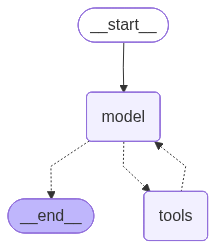

In [4]:
from langchain.agents import create_agent
from config import DEFAULT_MODEL

sql_agent = create_agent(
    model=DEFAULT_MODEL,
    tools=[execute_sql],
    name="sql_agent",
    system_prompt=SQL_AGENT_SYSTEM_PROMPT,
)
sql_agent

#### 🔒 Production Security Note

In this workshop, we're using keyword filtering to prevent write operations. In production PostgreSQL systems, you should implement defense-in-depth:

1. **Database-level**: Create a read-only user
2. **Connection-level**: Use SQLAlchemy's `postgresql_readonly=True` for example
3. **Application-level**: Validate queries before execution (our current approach)

SQLite doesn't support user roles, so our keyword approach is both educational and functional for this demo.

## 3. Quick Demo

Let's test the SQL agent on a query that previously failed in our baseline evaluation.


In [5]:
# Test on a query that requires aggregation
question = "What items were in order ORD-2023-0002? How much did each cost?"

result = sql_agent.invoke(
    {"messages": [{"role": "user", "content": question}]},
)

for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

What items were in order ORD-2023-0002? How much did each cost?
================================== Ai Message ==================================
Name: sql_agent

[{'text': "I'll look up the items in order ORD-2023-0002 and their costs.", 'type': 'text'}, {'id': 'toolu_01F4iE8eQcaHJXBHNPkcdkuv', 'input': {'query': "\nSELECT \n  oi.product_id,\n  p.name,\n  oi.quantity,\n  oi.price_per_unit,\n  (oi.quantity * oi.price_per_unit) as item_total\nFROM order_items oi\nJOIN products p ON oi.product_id = p.product_id\nWHERE oi.order_id = 'ORD-2023-0002'\nORDER BY oi.order_item_id\n"}, 'name': 'execute_sql', 'type': 'tool_use'}]
Tool Calls:
  execute_sql (toolu_01F4iE8eQcaHJXBHNPkcdkuv)
 Call ID: toolu_01F4iE8eQcaHJXBHNPkcdkuv
  Args:
    query: 
SELECT 
  oi.product_id,
  p.name,
  oi.quantity,
  oi.price_per_unit,
  (oi.quantity * oi.price_per_unit) as item_total
FROM order_items oi
JOIN products p ON oi.product_

✅ **Success!** The SQL agent generates a custom query with JOINs and aggregation to answer the question efficiently in just a single tool call.

Check the LangSmith trace to see the generated SQL query!


## 4. Integrate SQL Agent with Supervisor HITL

Now let's swap our old rigid DB agent with this flexible SQL agent in the full supervisor HITL system.


In [6]:
from agents.docs_agent import create_docs_agent
from agents.sql_agent import create_sql_agent
from agents.supervisor_hitl_agent import create_supervisor_hitl_agent

# Instantiate improved SQL agent for deployment
sql_agent = create_sql_agent()

# Instantiate docs agent
docs_agent = create_docs_agent()


# Compose supervisor HITL with SQL agent instead of old db_agent
improved_agent = create_supervisor_hitl_agent(
    db_agent=sql_agent,
    docs_agent=docs_agent,
)

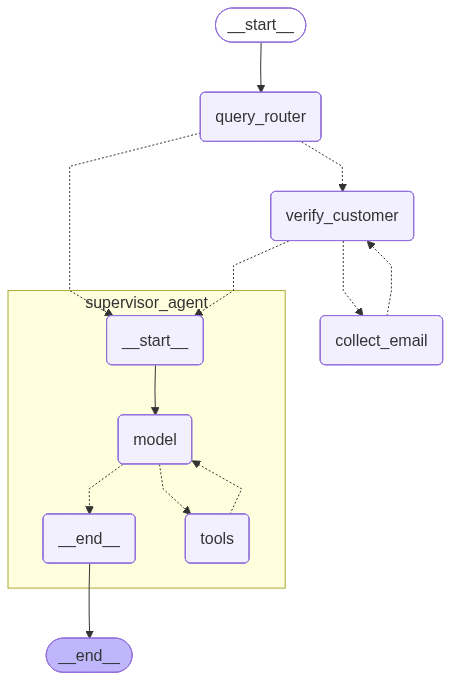

In [7]:
from IPython.display import Image

display(Image(improved_agent.get_graph(xray=True).draw_mermaid_png()))

Quick test:

In [8]:
import uuid
from langgraph.types import Command

# New thread
thread_id = uuid.uuid4()
config = {"configurable": {"thread_id": thread_id}}

# First invocation - will pause at interrupt
result = improved_agent.invoke(
    {"messages": [{"role": "user", "content": "Whats the status of my recent order?"}]},
    config=config,
)

result

{'messages': [HumanMessage(content='Whats the status of my recent order?', additional_kwargs={}, response_metadata={}, id='f3f7c906-4f21-429b-9dba-56ffd43f3d33'),
  AIMessage(content='To access information about your account or orders, please provide your email address.', additional_kwargs={}, response_metadata={}, id='d4cd44b2-3470-481c-980a-bd38c31c9ff4')],
 '__interrupt__': [Interrupt(value='Please provide your email:', id='d1ef644a97310ec4d279cb8998f481d3')]}

In [9]:
# Resume with valid email
result = improved_agent.invoke(
    Command(resume="Ok, its: sarah.chen@gmail.com"),
    config=config,
)
result

{'messages': [HumanMessage(content='Whats the status of my recent order?', additional_kwargs={}, response_metadata={}, id='f3f7c906-4f21-429b-9dba-56ffd43f3d33'),
  AIMessage(content='To access information about your account or orders, please provide your email address.', additional_kwargs={}, response_metadata={}, id='d4cd44b2-3470-481c-980a-bd38c31c9ff4'),
  HumanMessage(content='Ok, its: sarah.chen@gmail.com', additional_kwargs={}, response_metadata={}, id='90f8eb6e-efd9-420a-9a0f-007bc3e39857'),
  AIMessage(content='✓ Verified! Welcome back, Sarah Chen.', additional_kwargs={}, response_metadata={}, id='7dc00c85-aecb-4fbe-9b41-68fc466028d2'),
  AIMessage(content=[{'text': '\n\nLet me check the status of your recent order.', 'type': 'text'}, {'id': 'toolu_0168yPgWZpA6BJrUYG8tU4nE', 'input': {'query': 'What is the status of the most recent order for customer CUST-001 with email sarah.chen@gmail.com?'}, 'name': 'database_specialist', 'type': 'tool_use'}], additional_kwargs={}, response

In [10]:
for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

Whats the status of my recent order?
================================== Ai Message ==================================

To access information about your account or orders, please provide your email address.
================================ Human Message =================================

Ok, its: sarah.chen@gmail.com
================================== Ai Message ==================================

✓ Verified! Welcome back, Sarah Chen.
================================== Ai Message ==================================
Name: supervisor_agent

[{'text': '\n\nLet me check the status of your recent order.', 'type': 'text'}, {'id': 'toolu_0168yPgWZpA6BJrUYG8tU4nE', 'input': {'query': 'What is the status of the most recent order for customer CUST-001 with email sarah.chen@gmail.com?'}, 'name': 'database_specialist', 'type': 'tool_use'}]
Tool Calls:
  database_specialist (toolu_0168yPgWZpA6BJrUYG8tU4nE)
 Call ID: too

## 5. Re-evaluate Performance

Now let's run the same evaluation on the same dataset to quantitatively see how it impacts our performance metrics.


In [8]:
# Import evaluators from Section 1 (now packaged in evaluators module)
from evaluators import correctness_evaluator, count_total_tool_calls_evaluator

In [9]:
import uuid
from langsmith import Client

client = Client()


def improved_target_function(inputs: dict) -> dict:
    """Target function that wraps our improved agent for evaluation."""
    thread_id = uuid.uuid4()
    config = {"configurable": {"thread_id": thread_id}}

    result = improved_agent.invoke(
        inputs,
        config=config,
    )
    return {
        "messages": [{"role": "assistant", "content": result["messages"][-1].content}]
    }


# Get the most recent dataset name
most_recent_dataset_name = max(
    client.list_datasets(), key=lambda ds: ds.created_at
).name

# Run evaluation on same dataset
results = client.evaluate(
    improved_target_function,
    data=most_recent_dataset_name,  # Same dataset as section 1
    evaluators=[correctness_evaluator, count_total_tool_calls_evaluator],
    experiment_prefix="with-sql-agent-eval",
    description="Evaluate SQL agent's flexible query generation vs baseline rigid tools",
    max_concurrency=5,
)

View the evaluation results for experiment: 'with-sql-agent-eval-dce90923' at:
https://smith.langchain.com/o/5aa54808-d164-4ed7-bc4d-e5630f7ffd37/datasets/f529ec98-fd1c-4770-9912-3e51f95b4c89/compare?selectedSessions=a0e11e10-0a9a-4564-82d0-1dfb9dd25a6c




0it [00:00, ?it/s]

## 6. Compare Results in LangSmith

Now let's analyze our improvement using LangSmith's comparison features.